# Results

In [1]:
import warnings

warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fmriprep_denoise.visualization import utils, figures
from myst_nb import glue

---- repo2data starting ----
/home/haoting/.virtualenvs/connectome_confounds/lib/python3.8/site-packages/repo2data
Config from file :
/home/haoting/projects/fmriprep-denoise-benchmark/binder/data_requirement.json
Destination:
../../inputs/fmrieprep-denoise-paper

Info : ../../inputs/fmrieprep-denoise-paper already downloaded


## Level of motion in samples quitified by mean framewise displacement

In [2]:
from statsmodels.stats.weightstats import ttest_ind

for_plotting = {}

datasets = ['ds000228', 'ds000030']
baseline_groups = ['adult', 'CONTROL']
for dataset, baseline_group in zip(datasets, baseline_groups):
    data, groups = utils.load_meanfd_groups(dataset)
    baseline = data[data['Groups'] == baseline_group]
    for group in groups:
        compare = data[data['Groups'] == group]
        glue(
            f'{dataset}_{group}_mean',
            compare['mean_framewise_displacement'].mean(),
        )
        glue(
            f'{dataset}_{group}_sd',
            compare['mean_framewise_displacement'].std(),
        )
        glue(
            f'{dataset}_{group}_n',
            compare.shape[0],
        )
        if group != baseline_group:
            t_stats, pval, df = ttest_ind(
                baseline['mean_framewise_displacement'],
                compare['mean_framewise_displacement'],
                usevar='unequal',
            )
            glue(f'{dataset}_t_{group}', t_stats)
            glue(f'{dataset}_p_{group}', pval)
            glue(f'{dataset}_df_{group}', df)
    for_plotting.update({dataset: data})

0.3726003847486127

0.28907597426004483

122

-5.9903509055012885

1.5099409407527793e-08

148.7509307996301

0.1881064928771293

0.09326558238655397

33

0.1481063793068254

0.09222778467046405

40

0.971585519173292

0.33364250271851514

98.25741154156053

0.18898841573626907

0.11204297777465377

49

-1.104984542831525

0.2716510957218563

106.72791464040314

0.2640663292252491

0.19496102391926312

50

-3.2249218047054766

0.0019222336876664097

69.42137384033886

0.16666143888934684

0.13508817731182263

120

We will firstly characterise motion through the mean framewise displacement of each sample and the sub-groups.
This report will serve as a reference point for understanding the remainder of the results.
In `ds000228`, there was a significant difference in motion during the scan captured by mean framewise displacement 
between the child 
(M = {glue:text}`ds000228_child_mean:.2f`, SD = {glue:text}`ds000228_child_sd:.2f`, n = {glue:text}`ds000228_child_n:i`)
and adult sample
(M = {glue:text}`ds000228_adult_mean:.2f`, SD = {glue:text}`ds000228_adult_sd:.2f`, n = {glue:text}`ds000228_adult_n:i`,
t({glue:text}`ds000228_df_child:.2f`) = {glue:text}`ds000228_t_child:.2f`, p = {glue:text}`ds000228_p_child:.3f`,
This is consistent with the existing literature.
In `ds000030`, the only patient group shows a difference comparing to the
control 
(M = {glue:text}`ds000030_CONTROL_mean:.2f`, SD = {glue:text}`ds000030_CONTROL_sd:.2f`, n = {glue:text}`ds000030_CONTROL_n:i`)
is the schizophrania group 
(M = {glue:text}`ds000030_SCHZ_mean:.2f`, SD = {glue:text}`ds000030_SCHZ_sd:.2f`, n = {glue:text}`ds000030_SCHZ_n:i`;
t({glue:text}`ds000030_df_SCHZ:.2f`) = {glue:text}`ds000030_t_SCHZ:.2f`, p = {glue:text}`ds000030_p_SCHZ:.3f`).
There was no difference between the control and ADHD group
(M = {glue:text}`ds000030_ADHD_mean:.2f`, SD = {glue:text}`ds000030_ADHD_sd:.2f`, n = {glue:text}`ds000030_ADHD_n:i`;
t({glue:text}`ds000030_df_ADHD:.2f`) = {glue:text}`ds000030_t_ADHD:.2f`, p = {glue:text}`ds000030_p_ADHD:.3f`),
or the bipolar group 
(M = {glue:text}`ds000030_BIPOLAR_mean:.2f`, SD = {glue:text}`ds000030_BIPOLAR_sd:.2f`, n = {glue:text}`ds000030_BIPOLAR_n:i`;
t({glue:text}`ds000030_df_BIPOLAR:.2f`) = {glue:text}`ds000030_t_BIPOLAR:.2f`, p = {glue:text}`ds000030_p_BIPOLAR:.3f`).
In conclusion, adult samples has lower mean framewise displacement than a youth sample.

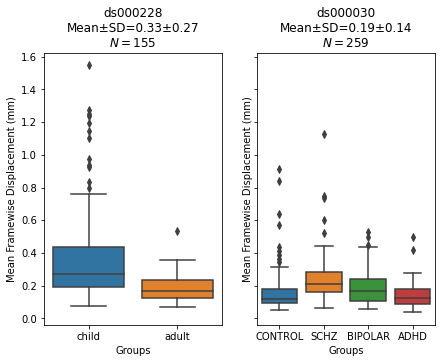

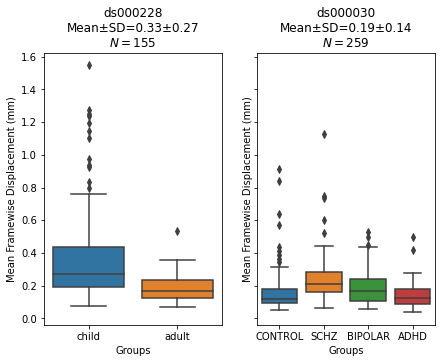

In [3]:
fig = plt.figure(figsize=(7, 5))
axs = fig.subplots(1, 2, sharey=True)
for dataset, ax in zip(for_plotting, axs):
    df = for_plotting[dataset]
    mean_fd = df['mean_framewise_displacement'].mean()
    sd_fd = df['mean_framewise_displacement'].std()
    df = df.rename(
        columns={
            'mean_framewise_displacement': 'Mean Framewise Displacement (mm)'
        }
    )
    sns.boxplot(
        y='Mean Framewise Displacement (mm)', x='Groups', data=df, ax=ax
    )
    ax.set_title(
        f'{dataset}\nMean\u00B1SD={mean_fd:.2f}\u00B1{sd_fd:.2f}\n$N={df.shape[0]}$'
    )
# fig.suptitle("Mean framewise displacement per sub-sample")

glue('meanFD-fig', fig, display=False)

```{glue:figure} meanFD-fig
:figwidth: 800px
:name: "tbl:meanFD-fig"

Mean framewise displacement of each dataset.
We found young subjects has higher motion comparing to adults,
which is consistent with the pattern described in the literature.
Amongst psychiatric conditiontions, only the schizophrania group shows difference to the control group.
```

## The loss in temporal degrees of freedom in different strategies

The common analysis and denoising methods are based on linear reagression.
Using more nuisance regressors can capture additional sources of noise-related variance in the data and thus improve denoising.
However, this comes at the expense of a loss of temporal degrees of freedom for statistical inference in further analysis.
This is an important point to consider along side the denoising performance.

In fMRIPrep, high-pass filtering is done through discrete cosine-basis regressors, 
labled as `cosine_*` in fMRIPrep confounds output.
In the following section, the number of discrete cosine-basis regressor will be denoted as $c$. 
Depending on the length of the scan, the number of discrete cosine-basis regressors can differ ($c_{ds000228}=4$, $c_{ds000030}=3$). 
The `simple` and `srubbing`-based strategy are the strategy with a fixed number of degree of freedom loss.
`compcor` and `aroma`-based strategies shows variability depending on the number of noise compoenets detected.
In theory, `compcor6` should also report a fixed number of degree of freedom loss.
However, fMRIPrep outputs the compcor compoenents based on the 50% variance cut-off.
For some subjects the number of components could be lower than 6, hence the variability.

In {cite:t}`ciric_benchmarking_2017`, the equivalent `aroma` and `aroma+gsr` strategies were reported with 
a lower magnitude of loss in temporal degrees of freedom than `scrubbing` or `simple` strategies.
However, we did not observe this advantage is limited to sample with relatively low motion (i.e. adults).
When selecting denoising strategy, 
The two datasets used in the current benchmark both contained subjects with behaviours deviating from the healthy controls.
`ds000228` is comprised of adult healthy controls and children.
`ds000030` includes healthy controls and subjects with three different psychiatric conditions.
the loss in degrees of freedom `simple` ($26 + c$) and `simple+gsr` ($27 + c$) used the least amount of regressors in the general population.
Certain sub-sample uses less regressors with the `aroma` and `aroma+gsr` strategies.
The reason potentially lies in the implementation of ICA-AROMA. 
ICA-AROMA uses pretrained model on healthy subjects to select noise components {cite:p}`aroma`.

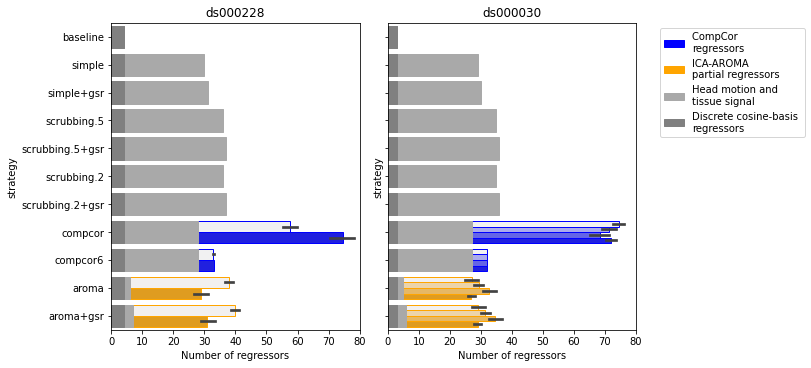

['child', 'adult']

['ADHD', 'BIPOLAR', 'SCHZ', 'CONTROL']

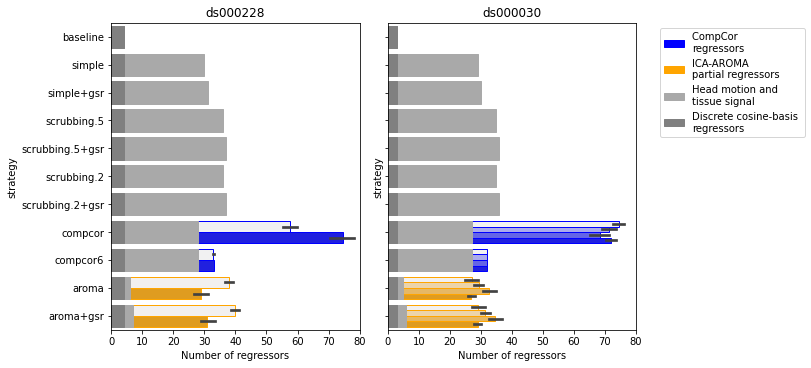

In [4]:
fig, ds_groups = figures.plot_dof_dataset()
glue(f'dof-fig', fig, display=False)
for ds, group in ds_groups:
    glue(f'group-order_{ds}', group, display=False)

```{glue:figure} dof-fig
:figwidth: 800px
:name: "tbl:dof-fig"

Loss in temporal degrees of freedom break down by groups.
`compcor` and `aroma`-based strategies shows variability depending on the number of noise compoenets detected.
The variability is broken down by groups.
From the lightest hue to the darkes, the order of the group in `ds000228` is:
{glue:}`group-order_ds000228`
From the lightest hue to the darkes, the order of the group in `ds000030` is:
{glue:}`group-order_ds000030`
```

To compare the loss in number of volumes from scrubbing base strategy across datasets,
we calculate the proportion of volume loss to number of volumes in a full scan.
`ds000228` includes child subjects and shows higher loss in volumes comparing to `ds000030` with adult subjects only.
In `ds000228`, the trend of volume scrubbed comparing adults and children fits the observation shown in literature {cite:p}`satterthwaite_impact_2012`.
In `ds000030`, the schizophrania group shows the highest amount of volumes scrubbed,
followed by the bipolar group, and comparable results between the control group and ADHD group.
With a stringent 0.2 mm threshold, groups with high motion will loose on average close to half of the volumes.

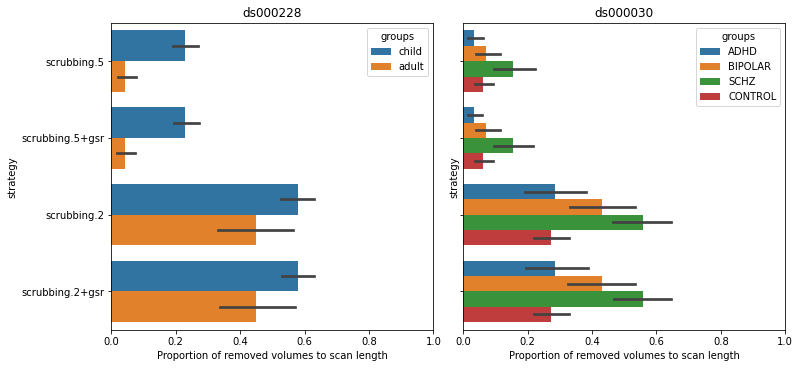

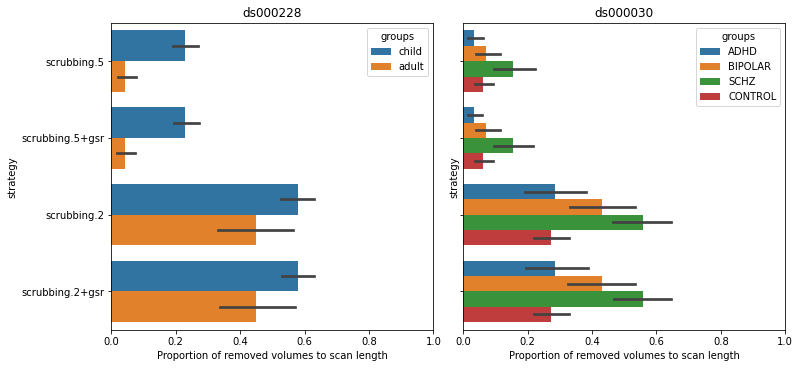

In [5]:
fig = figures.plot_vol_scrubbed_dataset()
glue(f'scrubbing-fig', fig, display=False)

```{glue:figure} scrubbing-fig
:figwidth: 800px
:name: "tbl:scrubbing-fig"

Loss in number of volumes break down by groups.
```


## Comparisons on the impacts of strategies on connectomes

The trend of benchmaker metrics does not differ amongst the choice of atlases.
However, we can see variance within the parcellation scheme MIST and DiFuMo.
The variance comes from different resolution of the same parcellation scheme, epecially with low parcel counts.

:::{dropdown} References on this page

```{bibliography}
:filter: docname in docnames
```
:::